Plot lipid 3D MINFLUX tracks at gag sites, in various ways in 2D cross sections or in 3D.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tiff
import matplotlib.cm as cm
import sys
sys.path.append("..")
import obf_support

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'arial'

def consecutive_bool(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def reject_outliers(data, m=3.):
    # from: https://stackoverflow.com/a/16562028
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    return data[s<m]

# manual parameters
window_pts = 70
len_lim = 10
dt_loc_thresh = 550
stdfact = 1.7
xdepth = 0.05
ydepth = 0.05
zstep = 0.04

parentdir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

In [3]:
folders = [os.path.join(parentdir, 'exampledata\\gag\\241114\\sample3\\e2'),
           os.path.join(parentdir, 'exampledata\\gag\\250117\\sample2\\e1'),
           os.path.join(parentdir, 'exampledata\\gag\\250117\\sample2\\e1')]
roinames = ['ROI0', 'ROI1', 'ROI5']

c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\gag\250117\sample2\e1\250117-175815_ROI5-Pos[152,49]-Size[0.70,0.70]-RecTime[34.npy
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\gag\250117\sample2\e1\250117-175732_conf-raw.tif
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\gag\250117\sample2\e1\250117-183952_minflux.msr


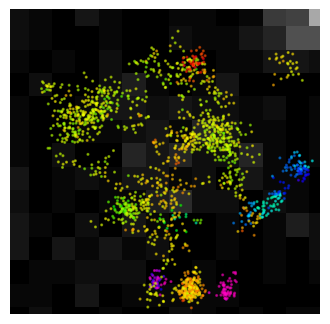

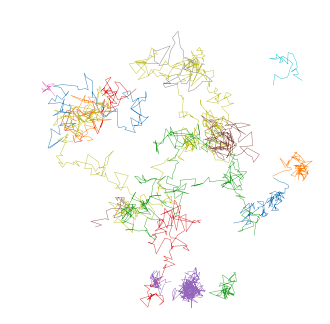

c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\gag\250117\sample2\e1\250117-180015_ROI5-Pos[152,49]-Size[0.70,0.70]-RecTime[34.npy
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\gag\250117\sample2\e1\250117-175932_conf-raw.tif
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\gag\250117\sample2\e1\250117-183952_minflux.msr


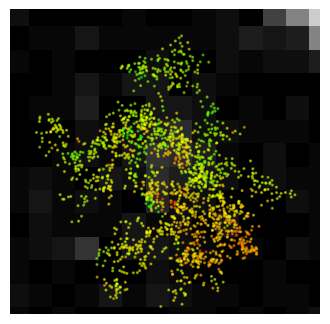

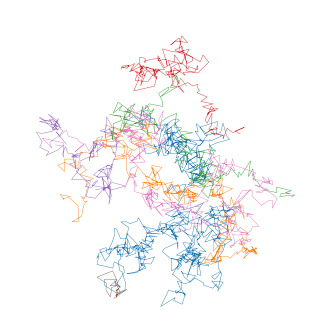

c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\gag\250117\sample2\e1\250117-180255_ROI5-Pos[152,49]-Size[0.70,0.70]-RecTime[54.npy
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\gag\250117\sample2\e1\250117-180151_conf-raw.tif
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\gag\250117\sample2\e1\250117-183952_minflux.msr


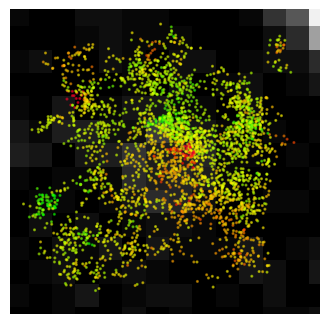

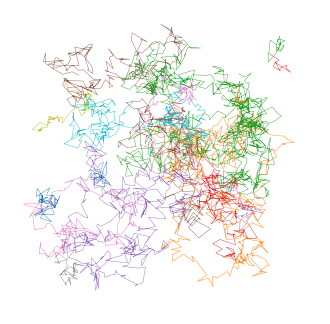

In [5]:
### Filter and plot all tracks in 2D XY
%matplotlib inline
plt.style.use('default')

folderidx = 2
roiidx = 2

folder = folders[folderidx]
roi_name = roinames[roiidx]
filelist_all = os.listdir(folder)
filelist_npy = [file for file in filelist_all if file.endswith('.npy') and roi_name in file]
filelist_conf = [file for file in filelist_all if file.endswith('.tif') if 'conf-raw' in file]
filelist_msr = [file for file in filelist_all if file.endswith('.msr')]

for tp in range(3):
    file_npy = os.path.join(folder, filelist_npy[tp])
    dataset = np.load(file_npy)
    print(file_npy)
    file_conf = os.path.join(folder, filelist_conf[tp])
    print(file_conf)
    file_msr = os.path.join(folder, filelist_msr[0])
    print(file_msr)

    # load msr file to read confocal image settings
    # get metadata from confocal image in msr file (pixel size, image shape, image size, origin offset)
    file_msr = os.path.join(folder, filelist_msr[0])
    msr_dataset = obf_support.File(file_msr)
    conf_msr_stack_index = 0
    conf_stack = msr_dataset.stacks[conf_msr_stack_index]
    pxsize = conf_stack.pixel_sizes[0]*1e6
    pxshift = pxsize/2
    conf_size_px = (conf_stack.shape[0], conf_stack.shape[1])
    conf_size = (conf_stack.lengths[0]*1e6, conf_stack.lengths[1]*1e6)
    conf_offset = (conf_stack.offsets[0]*1e6, conf_stack.offsets[1]*1e6)

    # load confocal image and imshow it
    file_rawtif = os.path.join(folder, filelist_conf[tp])
    conf_stack = tiff.imread(file_rawtif)
    conf_img = conf_stack[-1]

    fig3 = plt.figure(figsize=(4,4))
    ax3 = plt.gca()
    vmaxlim = 35
    conf_img_plot = ax3.imshow(conf_img, cmap='gray', alpha=1, vmax=vmaxlim)
    extents_confimg = np.array(conf_img_plot.get_extent())*pxsize+[pxsize/2, pxsize/2, pxsize/2, pxsize/2]+[conf_offset[0], conf_offset[0], conf_offset[1], conf_offset[1]]
    conf_img_plot.set_extent(extents_confimg)  # scale overlay image to the correct pixel size for the tracks

    roi_pos = (int(file_npy.split('[')[1].split(',')[0]),int(file_npy.split(']')[0].split(',')[1]))
    roi_pos_um = (roi_pos[0]*pxsize+conf_offset[0], roi_pos[1]*pxsize+conf_offset[1])

    # get all (x,y,z) coodinates and plot them in a 3D scatter
    loc_it = 4

    x = np.zeros((len(dataset),1))
    y = np.zeros((len(dataset),1))
    z = np.zeros((len(dataset),1))
    z1 = np.zeros((len(dataset),1))
    tid = np.zeros((len(dataset),1))
    tim = np.zeros((len(dataset),1))
    efo = np.zeros((len(dataset),1))
    for i in range(len(dataset)):
        x[i] = dataset[i][0][loc_it][2][0]
        y[i] = dataset[i][0][loc_it][2][1]
        z[i] = dataset[i][0][loc_it][2][2]
        z1[i] = dataset[i][0][1][2][2]
        efo[i] = dataset[i][0][loc_it][6]
        tid[i] = dataset[i][4]
        tim[i] = dataset[i][3]
    x = x * 1e6
    x = x.flatten()
    if tp==0:
        xlim = [np.min(x), np.max(x)]
    y = y * 1e6
    y = y.flatten()
    if tp==0:
        ylim = [np.min(y), np.max(y)]
    z = z * 1e6
    z = z * 0.7  # z scaling for immersion mismatch
    z = z.flatten()
    if tp==0:
        zlim = [np.min(z)+0.2, np.max(z)-0.2]
    z1 = z1 * 1e6
    z1 = z1.flatten()
    tid = tid.flatten()
    tim = tim.flatten()
    efo = efo.flatten()
    track_ids = list(map(int, set(tid)))
    track_ids.sort()
    data_df = pd.DataFrame(columns=['tridx', 'tim0', 'x', 'y', 'z', 'tim', 'dt', 'efo', 'lims', 'z1', 'z1_diff', 'z_std', 'z_range'])
    for track in track_ids[::]:
        data_row = []
        x_track = np.array([val for val,tr in zip(x,tid) if tr==track]).flatten()
        y_track = np.array([val for val,tr in zip(y,tid) if tr==track]).flatten()
        z_track = np.array([val for val,tr in zip(z,tid) if tr==track]).flatten()
        z1_track = np.array([val for val,tr in zip(z1,tid) if tr==track]).flatten()
        tim_track = np.array([val for val,tr in zip(tim,tid) if tr==track]).flatten()
        efo_track = np.array([val for val,tr in zip(efo,tid) if tr==track]).flatten()
        z_diff = z_track - z1_track[0]
        data_row.append(track)
        data_row.append(tim_track[0])
        data_row.append(x_track)
        data_row.append(y_track)
        data_row.append(z_track)
        tim_track = tim_track - tim_track[0]
        data_row.append(tim_track)
        data_row.append(np.diff(tim_track))
        data_row.append(efo_track)
        data_row.append([np.min(x), np.max(x), np.min(y), np.max(y), np.min(z), np.max(z)])
        data_row.append(z1_track)
        data_row.append(z_diff)
        data_row.append(np.std(z_track))
        data_row.append(np.max(z_track)-np.min(z_track))
        data_df = pd.concat([data_df, pd.DataFrame([data_row], columns=data_df.columns)], ignore_index=True)

    zstds = []
    zspans = []
    max_efo = 0
    max_tim = 0
    max_dt = 0

    fig1 = plt.figure(figsize=(4,4))
    ax1 = plt.gca()
    trs = np.arange(0,len(data_df))
    for tr in trs:
        dt_track_full = np.array(data_df.iloc[tr]['dt'])*1e6
        dt_track_full = np.insert(dt_track_full,0,0)
        if len(dt_track_full) > window_pts:
            local_dt_full = []
            for i in np.arange(0, len(dt_track_full)):
                if i > int(window_pts/2) and i < len(dt_track_full)-int(window_pts/2)-1:
                    local_dt_full.append(np.mean(dt_track_full[i-int(window_pts/2):i+int(window_pts/2)]))
                else:
                    local_dt_full.append(np.nan)
            local_dt_full = np.array(local_dt_full)
            idx_lists = consecutive_bool(np.argwhere(local_dt_full<dt_loc_thresh).flatten())
            # loop through all accepted tracks
            for idx_list in idx_lists:
                dt_track = dt_track_full[idx_list]
                if len(dt_track) > len_lim:
                    x_track = data_df.iloc[tr]['x'][idx_list]
                    y_track = data_df.iloc[tr]['y'][idx_list]
                    z_track = data_df.iloc[tr]['z'][idx_list]
                    tim_track = data_df.iloc[tr]['tim'][idx_list]
                    efo_track = data_df.iloc[tr]['efo'][idx_list]
                    local_dt = local_dt_full[idx_list]
                    z1_track = data_df.iloc[tr]['z1'][idx_list]
                    z1diff_track = data_df.iloc[tr]['z1_diff'][idx_list]
                    zstd = np.std(z_track)
                    zspan = np.max(z_track)-np.min(z_track)
                    zstds.append(zstd)
                    zspans.append(zspan)

                    if np.max(efo_track) > max_efo:
                        max_efo = np.max(efo_track)
                    if np.max(dt_track) > max_dt:
                        max_dt = np.max(dt_track)
                    if np.max(tim_track) > max_tim:
                        max_tim = np.max(tim_track)

                    local_efo = []
                    for i in np.arange(0, len(efo_track)):
                        if i > int(window_pts/2) and i < len(dt_track)-int(window_pts/2)-1:
                            local_efo.append(np.mean(efo_track[i-int(window_pts/2):i+int(window_pts/2)]))
                        else:
                            local_efo.append(np.nan)
                    sc = ax1.plot(x_track,y_track, linewidth=0.3)
                    sc = ax3.scatter(x_track,y_track,c=z_track,cmap=cm.gist_rainbow,s=1.5,alpha=0.5,vmin=-0.15,vmax=0.25)
    
    ax1.set_xlim(*xlim)
    ax1.set_ylim(*ylim)
    ax1.set_aspect('equal', adjustable='box')
    ax1.set_axis_off()
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax3.set_xlim(*xlim)
    ax3.set_ylim(*ylim)
    ax3.set_aspect('equal', adjustable='box')
    ax3.set_axis_off()

    plt.show()

c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\gag\250117\sample2\e1\250117-175815_ROI5-Pos[152,49]-Size[0.70,0.70]-RecTime[34.npy


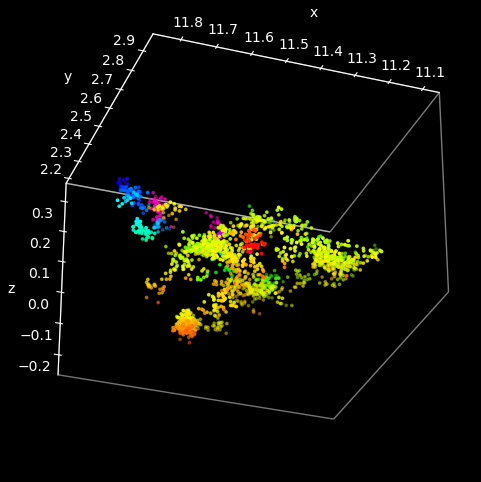

c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\gag\250117\sample2\e1\250117-180015_ROI5-Pos[152,49]-Size[0.70,0.70]-RecTime[34.npy


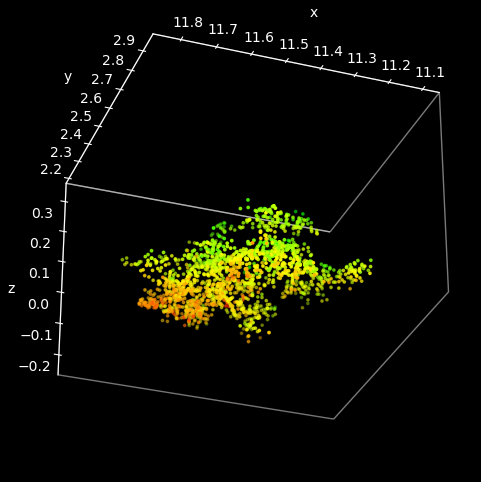

c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\gag\250117\sample2\e1\250117-180255_ROI5-Pos[152,49]-Size[0.70,0.70]-RecTime[54.npy


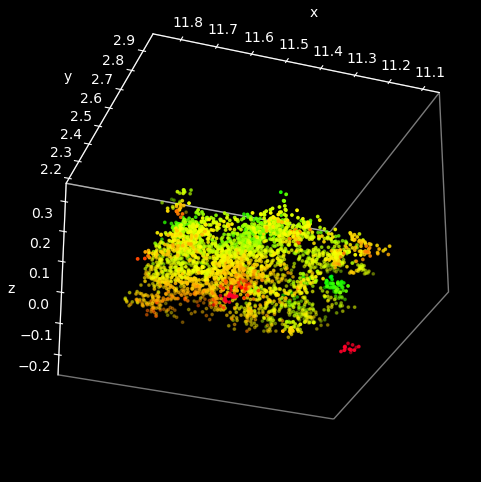

In [7]:
### Filter and plot all tracks in 3D, and plot some statistics on filtered tracks
%matplotlib inline
plt.style.use('dark_background')

filelist_all = os.listdir(folder)
filelist_npy = [file for file in filelist_all if file.endswith('.npy') and roi_name in file]
filelist_conf = [file for file in filelist_all if file.endswith('.tif') if 'conf-raw' in file]
filelist_msr = [file for file in filelist_all if file.endswith('.msr')]
for tp in range(3):
    file = os.path.join(folder, filelist_npy[tp])
    dataset = np.load(file)
    print(file)

    # get all (x,y,z) coodinates and plot them in a 3D scatter
    loc_it = 4

    x = np.zeros((len(dataset),1))
    y = np.zeros((len(dataset),1))
    z = np.zeros((len(dataset),1))
    z1 = np.zeros((len(dataset),1))
    tid = np.zeros((len(dataset),1))
    tim = np.zeros((len(dataset),1))
    efo = np.zeros((len(dataset),1))
    for i in range(len(dataset)):
        x[i] = dataset[i][0][loc_it][2][0]
        y[i] = dataset[i][0][loc_it][2][1]
        z[i] = dataset[i][0][loc_it][2][2]
        z1[i] = dataset[i][0][1][2][2]
        efo[i] = dataset[i][0][loc_it][6]
        tid[i] = dataset[i][4]
        tim[i] = dataset[i][3]
    x = x * 1e6
    x = x.flatten()
    if tp==0:
        xlim = [np.min(x), np.max(x)]
    y = y * 1e6
    y = y.flatten()
    if tp==0:
        ylim = [np.min(y), np.max(y)]
    z = z * 1e6
    z = z * 0.7  # z scaling for immersion mismatch
    z = z.flatten()
    if tp==0:
        zlim = [np.min(z), np.max(z)]
    z1 = z1 * 1e6
    z1 = z1.flatten()
    tid = tid.flatten()
    tim = tim.flatten()
    efo = efo.flatten()
    track_ids = list(map(int, set(tid)))
    track_ids.sort()
    data_df = pd.DataFrame(columns=['tridx', 'tim0', 'x', 'y', 'z', 'tim', 'dt', 'efo', 'lims', 'z1', 'z1_diff', 'z_std', 'z_range'])
    for track in track_ids[::]:
        data_row = []
        x_track = np.array([val for val,tr in zip(x,tid) if tr==track]).flatten()
        y_track = np.array([val for val,tr in zip(y,tid) if tr==track]).flatten()
        z_track = np.array([val for val,tr in zip(z,tid) if tr==track]).flatten()
        z1_track = np.array([val for val,tr in zip(z1,tid) if tr==track]).flatten()
        tim_track = np.array([val for val,tr in zip(tim,tid) if tr==track]).flatten()
        efo_track = np.array([val for val,tr in zip(efo,tid) if tr==track]).flatten()
        z_diff = z_track - z1_track[0]
        data_row.append(track)
        data_row.append(tim_track[0])
        data_row.append(x_track)
        data_row.append(y_track)
        data_row.append(z_track)
        tim_track = tim_track - tim_track[0]
        data_row.append(tim_track)
        data_row.append(np.diff(tim_track))
        data_row.append(efo_track)
        data_row.append([np.min(x), np.max(x), np.min(y), np.max(y), np.min(z), np.max(z)])
        data_row.append(z1_track)
        data_row.append(z_diff)
        data_row.append(np.std(z_track))
        data_row.append(np.max(z_track)-np.min(z_track))
        data_df = pd.concat([data_df, pd.DataFrame([data_row], columns=data_df.columns)], ignore_index=True)

    zstds = []
    zspans = []
    max_efo = 0
    max_tim = 0
    max_dt = 0

    fig1 = plt.figure(figsize=(20,6))
    ax1 = fig1.add_subplot(1,1,1,projection='3d')
    trs = np.arange(0,len(data_df))
    for tr in trs:
        dt_track_full = np.array(data_df.iloc[tr]['dt'])*1e6
        dt_track_full = np.insert(dt_track_full,0,0)
        if len(dt_track_full) > window_pts:
            local_dt_full = []
            for i in np.arange(0, len(dt_track_full)):
                if i > int(window_pts/2) and i < len(dt_track_full)-int(window_pts/2)-1:
                    local_dt_full.append(np.mean(dt_track_full[i-int(window_pts/2):i+int(window_pts/2)]))
                else:
                    local_dt_full.append(np.nan)
            local_dt_full = np.array(local_dt_full)
            idx_lists = consecutive_bool(np.argwhere(local_dt_full<dt_loc_thresh).flatten())
            # loop through all accepted tracks
            for idx_list in idx_lists:
                dt_track = dt_track_full[idx_list]
                if len(dt_track) > len_lim:
                    x_track = data_df.iloc[tr]['x'][idx_list]
                    y_track = data_df.iloc[tr]['y'][idx_list]
                    z_track = data_df.iloc[tr]['z'][idx_list]
                    tim_track = data_df.iloc[tr]['tim'][idx_list]
                    efo_track = data_df.iloc[tr]['efo'][idx_list]
                    local_dt = local_dt_full[idx_list]
                    z1_track = data_df.iloc[tr]['z1'][idx_list]
                    z1diff_track = data_df.iloc[tr]['z1_diff'][idx_list]
                    zstd = np.std(z_track)
                    zspan = np.max(z_track)-np.min(z_track)
                    zstds.append(zstd)
                    zspans.append(zspan)

                    if np.max(efo_track) > max_efo:
                        max_efo = np.max(efo_track)
                    if np.max(dt_track) > max_dt:
                        max_dt = np.max(dt_track)
                    if np.max(tim_track) > max_tim:
                        max_tim = np.max(tim_track)

                    local_efo = []
                    for i in np.arange(0, len(efo_track)):
                        if i > int(window_pts/2) and i < len(dt_track)-int(window_pts/2)-1:
                            local_efo.append(np.mean(efo_track[i-int(window_pts/2):i+int(window_pts/2)]))
                        else:
                            local_efo.append(np.nan)

                    sc = ax1.scatter(x_track,y_track,z_track,c=z_track,cmap=cm.gist_rainbow,vmin=-0.15,vmax=0.25,s=3)

    zlim = [-0.25, 0.35]

    ax1.view_init(-30, 70)
    plt.axis('scaled')
    ax1.set_zlim3d(*zlim)
    ax1.set_xlim3d(*xlim)
    ax1.set_ylim3d(*ylim)
    ax1.set_box_aspect([ub - lb for lb, ub in (getattr(ax1, f'get_{a}lim')() for a in 'xyz')])
    ax1.grid(False)
    #ax1.set_axis_off()
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('z')
    ax1.xaxis.pane.fill = False
    ax1.yaxis.pane.fill = False
    ax1.zaxis.pane.fill = False

    plt.show()

c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\gag\241114\sample3\e2\241114-180258_ROI0-Pos[54,166]-Size[0.80,0.80]-RecTime[24.npy


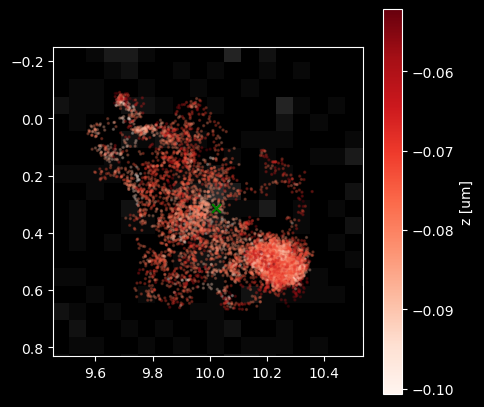

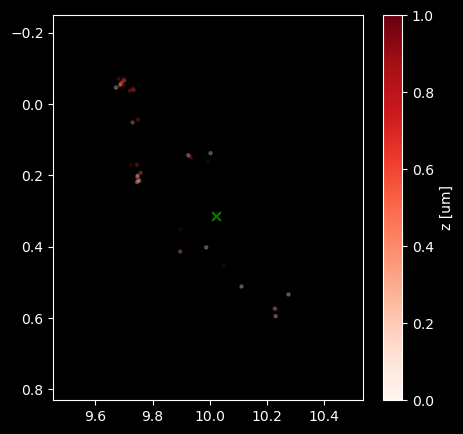

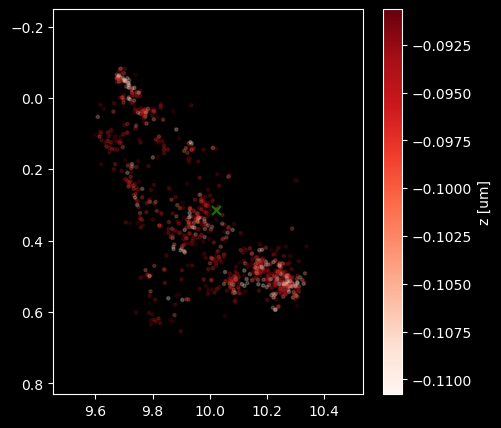

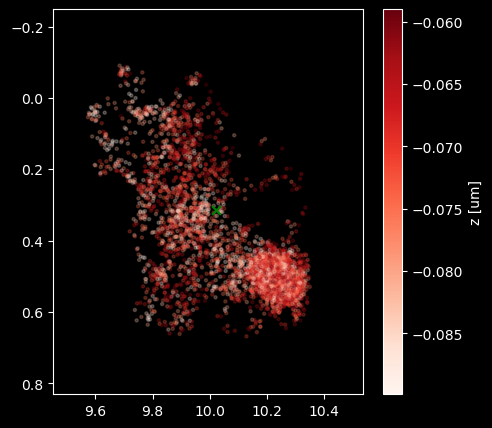

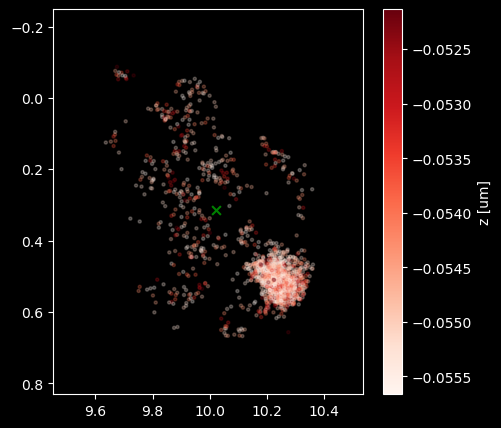

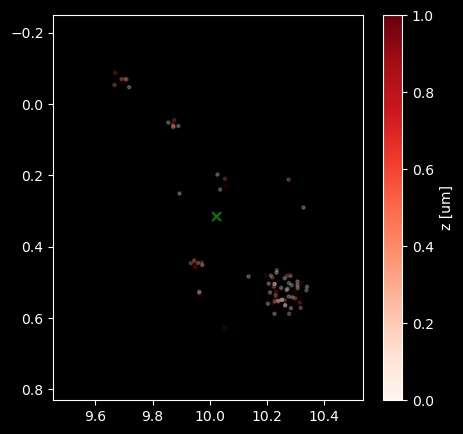

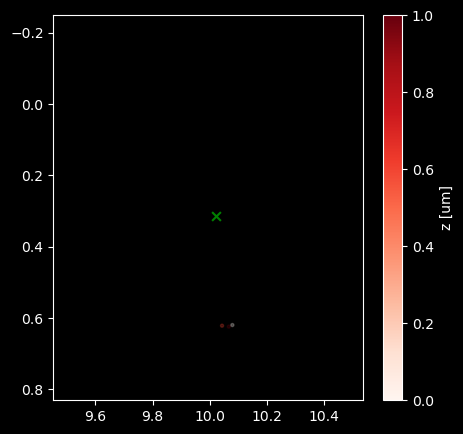

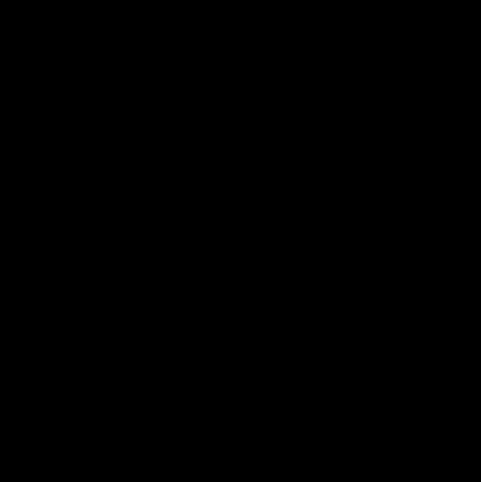

In [14]:
### Filter and plot all tracks in an XZ or YZ cross section
%matplotlib inline

tp = 0  # timepoint/cycle to plot

filelist = os.listdir(folder)
filelist = [file for file in filelist if file.endswith('.npy')]
file = os.path.join(folder, filelist[tp])
dataset = np.load(file)
print(file)

# get all (x,y,z) coodinates and plot them in a 3D scatter
loc_it = 4

x = np.zeros((len(dataset),1))
y = np.zeros((len(dataset),1))
z = np.zeros((len(dataset),1))
z1 = np.zeros((len(dataset),1))
tid = np.zeros((len(dataset),1))
tim = np.zeros((len(dataset),1))
efo = np.zeros((len(dataset),1))
for i in range(len(dataset)):
    x[i] = dataset[i][0][loc_it][2][0]
    y[i] = dataset[i][0][loc_it][2][1]
    z[i] = dataset[i][0][loc_it][2][2]
    z1[i] = dataset[i][0][1][2][2]
    efo[i] = dataset[i][0][loc_it][6]
    tid[i] = dataset[i][4]
    tim[i] = dataset[i][3]
x = x * 1e6
x = x.flatten()
y = y * 1e6
y = y.flatten()
z = z * 1e6
z = z * 0.7  # z scaling for immersion mismatch
z = z.flatten()
z1 = z1 * 1e6
z1 = z1.flatten()
tid = tid.flatten()
tim = tim.flatten()
efo = efo.flatten()
track_ids = list(map(int, set(tid)))
track_ids.sort()
data_df = pd.DataFrame(columns=['tridx', 'tim0', 'x', 'y', 'z', 'tim', 'dt', 'efo', 'lims', 'z1', 'z1_diff', 'z_std', 'z_range'])
for track in track_ids[::]:
    data_row = []
    x_track = np.array([val for val,tr in zip(x,tid) if tr==track]).flatten()
    y_track = np.array([val for val,tr in zip(y,tid) if tr==track]).flatten()
    z_track = np.array([val for val,tr in zip(z,tid) if tr==track]).flatten()
    z1_track = np.array([val for val,tr in zip(z1,tid) if tr==track]).flatten()
    tim_track = np.array([val for val,tr in zip(tim,tid) if tr==track]).flatten()
    efo_track = np.array([val for val,tr in zip(efo,tid) if tr==track]).flatten()
    z_diff = z_track - z1_track[0]
    data_row.append(track)
    data_row.append(tim_track[0])
    data_row.append(x_track)
    data_row.append(y_track)
    data_row.append(z_track)
    tim_track = tim_track - tim_track[0]
    data_row.append(tim_track)
    data_row.append(np.diff(tim_track))
    data_row.append(efo_track)
    data_row.append([np.min(x), np.max(x), np.min(y), np.max(y), np.min(z), np.max(z)])
    data_row.append(z1_track)
    data_row.append(z_diff)
    data_row.append(np.std(z_track))
    data_row.append(np.max(z_track)-np.min(z_track))
    data_df = pd.concat([data_df, pd.DataFrame([data_row], columns=data_df.columns)], ignore_index=True)

zstds = []
zspans = []
max_efo = 0
max_tim = 0
max_dt = 0

fig1 = plt.figure(figsize=(20,6))
ax1 = fig1.add_subplot(1,1,1,projection='3d')
trs = np.arange(0,len(data_df))
for tr in trs:
    dt_track_full = np.array(data_df.iloc[tr]['dt'])*1e6
    dt_track_full = np.insert(dt_track_full,0,0)
    if len(dt_track_full) > window_pts:
        local_dt_full = []
        for i in np.arange(0, len(dt_track_full)):
            if i > int(window_pts/2) and i < len(dt_track_full)-int(window_pts/2)-1:
                local_dt_full.append(np.mean(dt_track_full[i-int(window_pts/2):i+int(window_pts/2)]))
            else:
                local_dt_full.append(np.nan)
        local_dt_full = np.array(local_dt_full)
        idx_lists = consecutive_bool(np.argwhere(local_dt_full<dt_loc_thresh).flatten())
        # loop through all accepted tracks
        for idx_list in idx_lists:
            dt_track = dt_track_full[idx_list]
            if len(dt_track) > len_lim:
                x_track = data_df.iloc[tr]['x'][idx_list]
                y_track = data_df.iloc[tr]['y'][idx_list]
                z_track = data_df.iloc[tr]['z'][idx_list]
                tim_track = data_df.iloc[tr]['tim'][idx_list]
                efo_track = data_df.iloc[tr]['efo'][idx_list]
                y_track = y_track[np.abs(x_track-11.2)<0.05]
                z_track = z_track[np.abs(x_track-11.2)<0.05]
                x_track = x_track[np.abs(x_track-11.2)<0.05]

                if np.max(efo_track) > max_efo:
                    max_efo = np.max(efo_track)
                if np.max(dt_track) > max_dt:
                    max_dt = np.max(dt_track)
                if np.max(tim_track) > max_tim:
                    max_tim = np.max(tim_track)

                local_efo = []
                for i in np.arange(0, len(efo_track)):
                    if i > int(window_pts/2) and i < len(dt_track)-int(window_pts/2)-1:
                        local_efo.append(np.mean(efo_track[i-int(window_pts/2):i+int(window_pts/2)]))
                    else:
                        local_efo.append(np.nan)

                sc = ax1.scatter(x_track,y_track,z_track,c=z_track,cmap=cm.gist_rainbow, vmin=-0.1,vmax=0.1,s=0.5)
ax1.view_init(0, 0)
plt.axis('scaled')
ax1.set_box_aspect([ub - lb for lb, ub in (getattr(ax1, f'get_{a}lim')() for a in 'xyz')])
ax1.grid(False)
ax1.set_axis_off()
plt.style.use('dark_background')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False

plt.show()